In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data fetched from SEC API using sec_edgar_fetcher.py
df_edgar = pd.read_csv("../Data/sec_data/pivoted_financial_data_2010_full.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../Data/sec_data/pivoted_financial_data_2010_full.csv'

In [ ]:
# Extract the missing values, will be used to help with feature selection
missing_edgar = df_edgar.isna().sum()
missing_edgar = missing_edgar.sort_values()
missing_edgar.head(30)

ticker                    0
date                      0
IncomeTax               900
DilutedShares          1914
WeightedShares         1974
Assets                 2380
Liabilities            2445
NetIncome              2800
FinancingCashFlow      3173
InvestingCashFlow      3199
OperatingCashFlow      3304
StockholdersEquity     4072
PPE                    5262
Goodwill               6408
CurrentAssets          6838
CurrentLiabilities     6850
OperatingIncome        7182
ShareBasedComp         7464
InterestExpense        8732
CapEx                  8748
Revenue               10527
SGA                   12655
Amortization          14025
GrossProfit           16408
COGS                  16964
LongTermDebt          17783
OperatingExpenses     21111
RnD                   21294
dtype: int64

In [ ]:
df_edgar.columns

Index(['ticker', 'date', 'Amortization', 'Assets', 'COGS', 'CapEx',
       'CurrentAssets', 'CurrentLiabilities', 'DilutedShares',
       'FinancingCashFlow', 'Goodwill', 'GrossProfit', 'IncomeTax',
       'InterestExpense', 'InvestingCashFlow', 'Liabilities', 'LongTermDebt',
       'NetIncome', 'OperatingCashFlow', 'OperatingExpenses',
       'OperatingIncome', 'PPE', 'Revenue', 'RnD', 'SGA', 'ShareBasedComp',
       'StockholdersEquity', 'WeightedShares'],
      dtype='object')

In [ ]:
# Transforming json cik file to csv for easier use
import json

json_data = pd.read_json("../Data/company_tickers.json").T
json_data.columns = ["cik", "ticker", "company_name"]
json_data.to_csv("../Data/company_tickers.csv", index=False)

In [ ]:
# Reading data on 345 filings (insider trades) from Q1 2010, 2019, and 2024.
# This data contains exact tickers which allows me to get CIKs for companies that are missing in the edgar data.

df345_2010 = pd.read_csv("../Data/345-filings/SUBMISSION_2010Q1.tsv", sep='\t')
df345_2019 = pd.read_csv("../Data/345-filings/SUBMISSION_2019Q1.tsv", sep='\t')
df345_2024 = pd.read_csv("../Data/345-filings/SUBMISSION_2024Q1.tsv", sep='\t')

# Select relevant columns and drop duplicates
df345_2010 = df345_2010[['ISSUERCIK', 'ISSUERNAME', 'ISSUERTRADINGSYMBOL']].drop_duplicates()
df345_2019 = df345_2019[['ISSUERCIK', 'ISSUERNAME', 'ISSUERTRADINGSYMBOL']].drop_duplicates()
df345_2024 = df345_2024[['ISSUERCIK', 'ISSUERNAME', 'ISSUERTRADINGSYMBOL']].drop_duplicates()

# Rename columns for consistency
df345_2010.columns = ["cik", "company_name", "ticker"]
df345_2019.columns = ["cik", "company_name", "ticker"]
df345_2024.columns = ["cik", "company_name", "ticker"]

# Combine dataframes
df_combined = pd.concat([df345_2010, df345_2019, df345_2024])

# Drop duplicates to get unique rows
df_unique_ciks = df_combined.drop_duplicates()

df_unique_ciks

,cik,company_name,ticker
0,355627,CTI GROUP HOLDINGS INC,CTIG
1,1289592,"Tower Group, Inc.",TWGP
2,1022345,MARINER ENERGY INC,ME
3,1401688,"Vitacost.com, Inc.",VITC
4,857005,PARAMETRIC TECHNOLOGY CORP,PMTC
...,...,...,...
67107,1064722,GIVEMEPOWER CORP,GMPW
67126,1832487,"Guerrilla RF, Inc.",GUER
67134,1809750,Edible Garden AG Inc,EDBL
67239,1834032,Constellation Acquisition Corp I,CSTAF


In [ ]:
# Create final file with all company tickers and ciks combined.
company_tickers = pd.read_csv("../Data/company_tickers.csv")
combined_df = pd.concat([df_unique_ciks, company_tickers]).drop_duplicates().reset_index(drop=True)
combined_df.to_csv("../Data/combined_company_tickers.csv", index=False)
combined_df

,cik,company_name,ticker
0,355627,CTI GROUP HOLDINGS INC,CTIG
1,1289592,"Tower Group, Inc.",TWGP
2,1022345,MARINER ENERGY INC,ME
3,1401688,"Vitacost.com, Inc.",VITC
4,857005,PARAMETRIC TECHNOLOGY CORP,PMTC
...,...,...,...
15122,2032528,Roman DBDR Acquisition Corp. II,DRDBW
15123,2028027,Newbury Street II Acquisition Corp,NTWOW
15124,2028027,Newbury Street II Acquisition Corp,NTWOU
15125,2023554,Sandisk Corp,SNDKV


In [ ]:
# Tag analysis
tags = pd.read_csv("../Data/sec_data/tag_frequencies.csv")
sp500_2010 = pd.read_csv("../Data/sp500_tickers_2010.csv")

# Basic coverage analysis
total_companies = sp500_2010.shape[0]
tags['coverage_percentage'] = (tags['company_count'] / total_companies * 100).round(2)

# Top 20 tags by coverage
tag_coverage = tags.sort_values('coverage_percentage', ascending=False)
tag_coverage = tag_coverage[['tag', 'coverage_percentage', 'company_count', 'avg_values_per_company']]
tag_coverage.head(20)

,tag,coverage_percentage,company_count,avg_values_per_company
0,Assets,97.60,487,113.97
1,LiabilitiesAndStockholdersEquity,97.60,487,107.65
2,NetCashProvidedByUsedInFinancingActivities,97.39,486,104.54
3,NetCashProvidedByUsedInInvestingActivities,97.39,486,104.43
4,IncomeTaxExpenseBenefit,97.39,486,178.02
5,NetCashProvidedByUsedInOperatingActivities,96.59,482,105.01
8,WeightedAverageNumberOfSharesOutstandingBasic,96.39,481,172.08
7,EarningsPerShareBasic,96.39,481,218.48
6,WeightedAverageNumberOfDilutedSharesOutstanding,96.39,481,172.27
10,EarningsPerShareDiluted,96.19,480,220.95


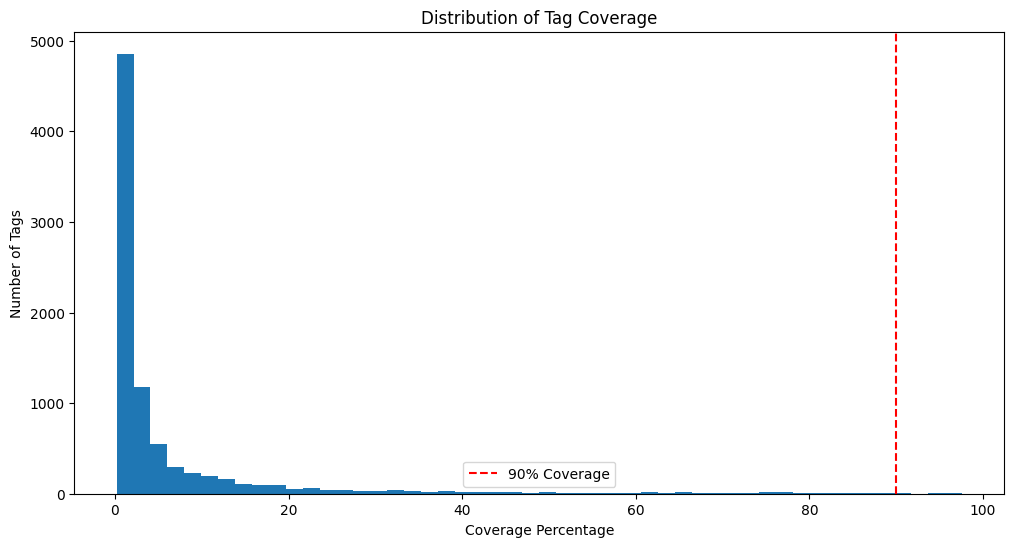

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(tag_coverage['coverage_percentage'], bins=50)
plt.title('Distribution of Tag Coverage')
plt.xlabel('Coverage Percentage')
plt.ylabel('Number of Tags')
plt.axvline(x=90, color='r', linestyle='--', label='90% Coverage')
plt.legend()
plt.show()

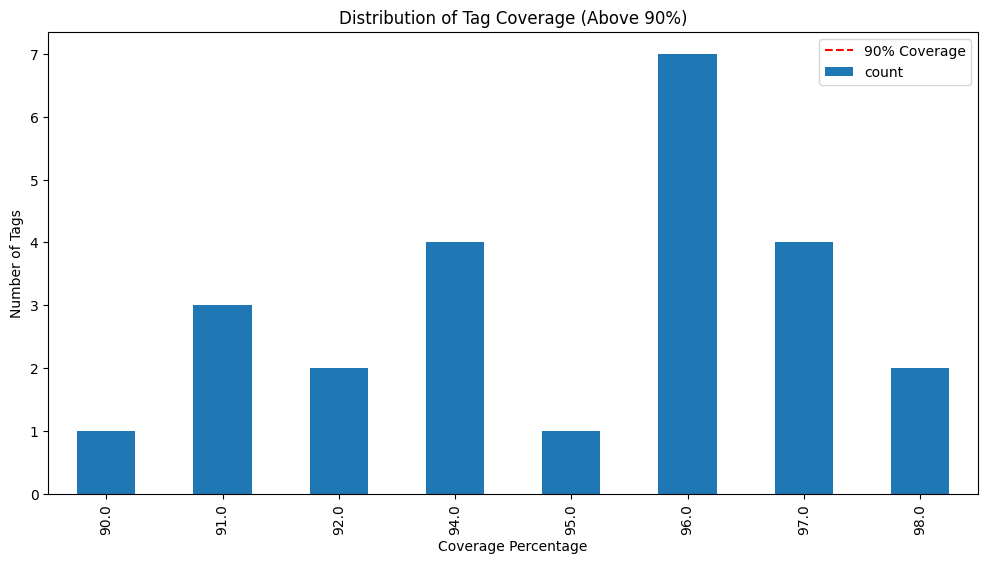

In [ ]:
# Filter tags with coverage percentage above 90
high_coverage_tags = tag_coverage[tag_coverage['coverage_percentage'] > 90]

plt.figure(figsize=(12, 6))
plt.hist(high_coverage_tags['coverage_percentage'], bins=12)
plt.title('Distribution of Tag Coverage (Above 90%)')
plt.xlabel('Coverage Percentage')
plt.ylabel('Number of Tags')
plt.axvline(x=90, color='r', linestyle='--', label='90% Coverage')
plt.legend()
plt.show()

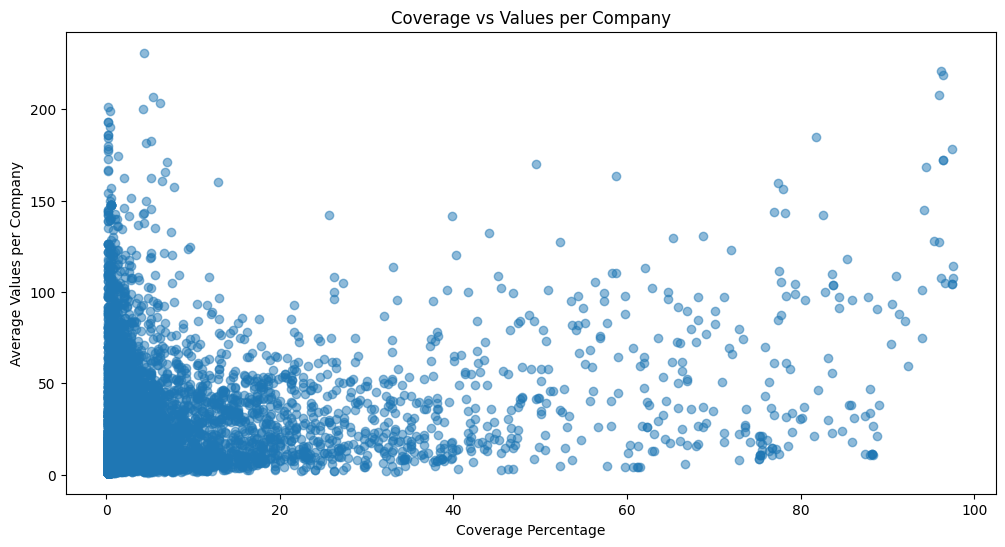

In [ ]:
# Scatter plot of coverage vs values per company
plt.figure(figsize=(12, 6))
plt.scatter(tag_coverage['coverage_percentage'], tag_coverage['avg_values_per_company'], alpha=0.5)
plt.title('Coverage vs Values per Company')
plt.xlabel('Coverage Percentage')
plt.ylabel('Average Values per Company')
plt.show()

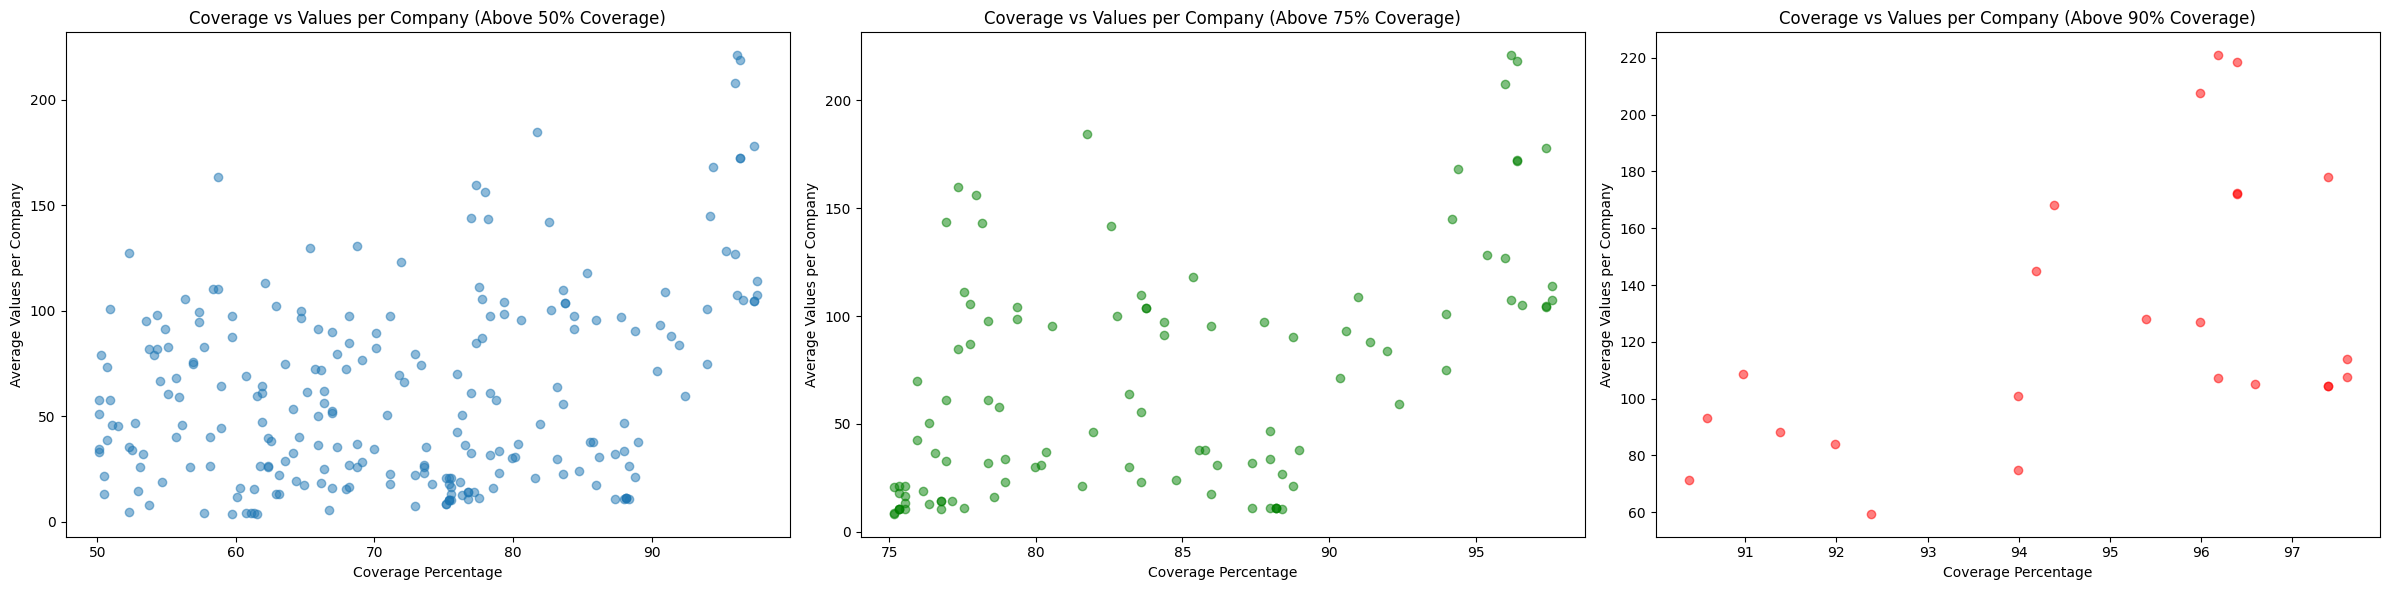

In [ ]:
# Filter tags with coverage percentage above 50
tags_above_50 = tag_coverage[tag_coverage['coverage_percentage'] > 50]

# Filter tags with coverage percentage above 75
tags_above_75 = tag_coverage[tag_coverage['coverage_percentage'] > 75]

# Split plot to show tags above 50%, 75%, and 90% coverage
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

# Scatter plot for tags above 50% coverage
axes[0].scatter(tags_above_50['coverage_percentage'], tags_above_50['avg_values_per_company'], alpha=0.5)
axes[0].set_title('Coverage vs Values per Company (Above 50% Coverage)')
axes[0].set_xlabel('Coverage Percentage')
axes[0].set_ylabel('Average Values per Company')

# Scatter plot for tags above 75% coverage
axes[1].scatter(tags_above_75['coverage_percentage'], tags_above_75['avg_values_per_company'], alpha=0.5, color='green')
axes[1].set_title('Coverage vs Values per Company (Above 75% Coverage)')
axes[1].set_xlabel('Coverage Percentage')
axes[1].set_ylabel('Average Values per Company')

# Scatter plot for tags above 90% coverage
axes[2].scatter(high_coverage_tags['coverage_percentage'], high_coverage_tags['avg_values_per_company'], alpha=0.5, color='red')
axes[2].set_title('Coverage vs Values per Company (Above 90% Coverage)')
axes[2].set_xlabel('Coverage Percentage')
axes[2].set_ylabel('Average Values per Company')

plt.tight_layout()
plt.show()

In [ ]:

# Find high quality tags (high coverage and many values)
good_tags = tag_coverage[
    (tag_coverage['coverage_percentage'] >= 90) & 
    (tag_coverage['avg_values_per_company'] >= 50)
].sort_values('coverage_percentage', ascending=False)

print("\nHigh quality tags (>90% coverage, >50 values/company):")
good_tags[['tag', 'coverage_percentage', 'avg_values_per_company', 'company_count']]


High quality tags (>90% coverage, >50 values/company):


,tag,coverage_percentage,avg_values_per_company,company_count
0,Assets,97.60,113.97,487
1,LiabilitiesAndStockholdersEquity,97.60,107.65,487
2,NetCashProvidedByUsedInFinancingActivities,97.39,104.54,486
3,NetCashProvidedByUsedInInvestingActivities,97.39,104.43,486
4,IncomeTaxExpenseBenefit,97.39,178.02,486
5,NetCashProvidedByUsedInOperatingActivities,96.59,105.01,482
8,WeightedAverageNumberOfSharesOutstandingBasic,96.39,172.08,481
7,EarningsPerShareBasic,96.39,218.48,481
6,WeightedAverageNumberOfDilutedSharesOutstanding,96.39,172.27,481
10,EarningsPerShareDiluted,96.19,220.95,480


In [4]:
df_delisted = pd.read_csv('../data/delisted_companies/US_LIST_OF_SYMBOLS.csv')
df_delisted.head(20)

,Code,Name,Country,Exchange,Currency,Type,Isin
0,AAAB,Admiralty Bancorp Inc,USA,NASDAQ,USD,Common Stock,NaN
1,AAADX,ALPINE RISING DIVIDEND FUND CLASS A,USA,NMFQS,USD,FUND,US0030224499
2,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,USA,NMFQS,USD,FUND,NaN
3,AAAGY,Altana Aktiengesellschaft,USA,NYSE,USD,Common Stock,NaN
4,AAAID,AAAID,USA,PINK,USD,Common Stock,NaN
5,AAAIF,Alternative Investment Trust,USA,PINK,USD,FUND,NaN
6,AAALF,Aareal Bank AG,USA,PINK,USD,Common Stock,NaN
7,AAALY,Aareal Bank AG ADR,USA,PINK,USD,Common Stock,US00254K1088
8,AAAP,Advanced Accelerator Applications S.A,USA,NASDAQ,USD,Common Stock,US00790T1007
9,AAARF,Aluar Aluminio Argentino S.A.I.C,USA,OTCGREY,USD,Common Stock,NaN


In [ ]:
df_tickers = pd.read_csv("../data/tickers/combined_company_tickers.csv")
df_tickers

,cik,company_name,ticker
0,355627,CTI GROUP HOLDINGS INC,CTIG
1,1289592,"Tower Group, Inc.",TWGP
2,1022345,MARINER ENERGY INC,ME
3,1401688,"Vitacost.com, Inc.",VITC
4,857005,PARAMETRIC TECHNOLOGY CORP,PMTC
...,...,...,...
15122,2032528,Roman DBDR Acquisition Corp. II,DRDBW
15123,2028027,Newbury Street II Acquisition Corp,NTWOW
15124,2028027,Newbury Street II Acquisition Corp,NTWOU
15125,2023554,Sandisk Corp,SNDKV


In [ ]:
df_delisted.join(df_tickers, on=Code=ticker)